# USGS Gages Filter
### Overview: Filter USGS gages based on the record availability and drainage area similarity for a given USGS station.

#### References:
##### [USGS Package Overview](https://owi.usgs.gov/R/dataRetrieval.html)
##### [GitHub Repo](https://github.com/USGS-R/dataRetrieval)
##### [CRAN](https://cran.r-project.org/web/packages/dataRetrieval/dataRetrieval.pdf)
##### [USGS Parameter Code](https://nwis.waterdata.usgs.gov/usa/nwis/pmcodes?radio_pm_search=param_group&pm_group=All+--+include+all+parameter+groups&pm_search=&casrn_search=&srsname_search=&format=html_table&show=parameter_group_nm&show=parameter_nm&show=casrn&show=srsname&show=parameter_units)

### Install and load required R packages

In [1]:
# Remove all objectts from R memory
rm(list=ls())

# List all required packages
list.of.packages <- c("dataRetrieval",
                      "curl",
                      "repr",
                      "maps",
                      "dplyr",
                      "ggplot2",
                      "leaflet",
                      "htmlwidgets")


# Install any required pacakage
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
lapply(list.of.packages, require, character.only = TRUE)
options(repr.matrix.max.cols = 40)


Loading required package: dataRetrieval
Loading required package: curl
Loading required package: repr
Loading required package: maps
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: leaflet
Loading required package: htmlwidgets


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

In [2]:
# Given station information to look around for similar USGS gages (based on drainge area) and with sufficient records
site_no <- "01651000"
paraCode <- "00060"
years_of_records <- 20
da_epsilon <- 0.25
bbox_delta <- 1.0 # Degrees


In [3]:
# Get site coordinates to build Bbox
site_data <- whatNWISsites(siteNumber=site_no, parameterCd=paraCode)
site_lat <- site_data$dec_lat_va
site_long <- site_data$dec_long_va

# Get site drainage area
site_summary <- readNWISsite(siteNumber=site_no)
site_da <- site_summary$drain_area_va

site_data

site_summary

agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,colocated,queryTime
USGS,01651000,"NORTHWEST BR ANACOSTIA RIVER NR HYATTSVILLE, MD",ST,38.95233,-76.96606,FALSE,2019-08-07 14:25:11


agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,coord_datum_cd,dec_coord_datum_cd,district_cd,state_cd,county_cd,country_cd,land_net_ds,map_nm,map_scale_fc,alt_va,...,alt_datum_cd,huc_cd,basin_cd,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,tz_cd,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
USGS,01651000,"NORTHWEST BR ANACOSTIA RIVER NR HYATTSVILLE, MD",ST,385708.4,765757.8,38.95233,-76.96606,M,S,NAD83,NAD83,24,24,033,US,NA,NA,NA,16.35,...,NAVD88,02070010,NA,NA,YYNNYNYNNYNNNNNNNNNNNNNNNNNNNN,NA,NA,49.4,NA,EST,Y,NA,NNNNNNNN,NA,NA,NA,NA,NA,NA,NA


In [4]:
para_sites <- data.frame()

bbox <- c(site_long - bbox_delta, 
          site_lat - bbox_delta, 
          site_long + bbox_delta, 
          site_lat + bbox_delta)

# Get site metadata for the Bbox
para_sites <- whatNWISsites(bBox= bbox, parameterCd=paraCode)
para_sites$gtype = paraCode #gtype: gage type (stage, flow, ...etc)

head(para_sites)

agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,colocated,queryTime,gtype
USGS,01663500,"HAZEL RIVER AT RIXEYVILLE, VA",ST,38.59179,-77.96500,FALSE,2019-08-07 14:25:14,00060
USGS,01616500,"OPEQUON CREEK NEAR MARTINSBURG, WV",ST,39.42371,-77.93861,FALSE,2019-08-07 14:25:14,00060
USGS,01616425,"HOPEWELL RUN AT LEETOWN, WV",ST,39.35464,-77.93361,FALSE,2019-08-07 14:25:14,00060
USGS,01643643,"GOOSE CREEK AT DELAPLANE, VA",ST,38.91428,-77.92194,FALSE,2019-08-07 14:25:14,00060
USGS,391805077550701,Jef-0528(Aldridge Spring),SP,39.30149,-77.91833,FALSE,2019-08-07 14:25:14,00060
USGS,01661977,"CARTER RUN AT ROUTE 681 NEAR JEFFERSONTON, VA",ST,38.72447,-77.91053,FALSE,2019-08-07 14:25:14,00060


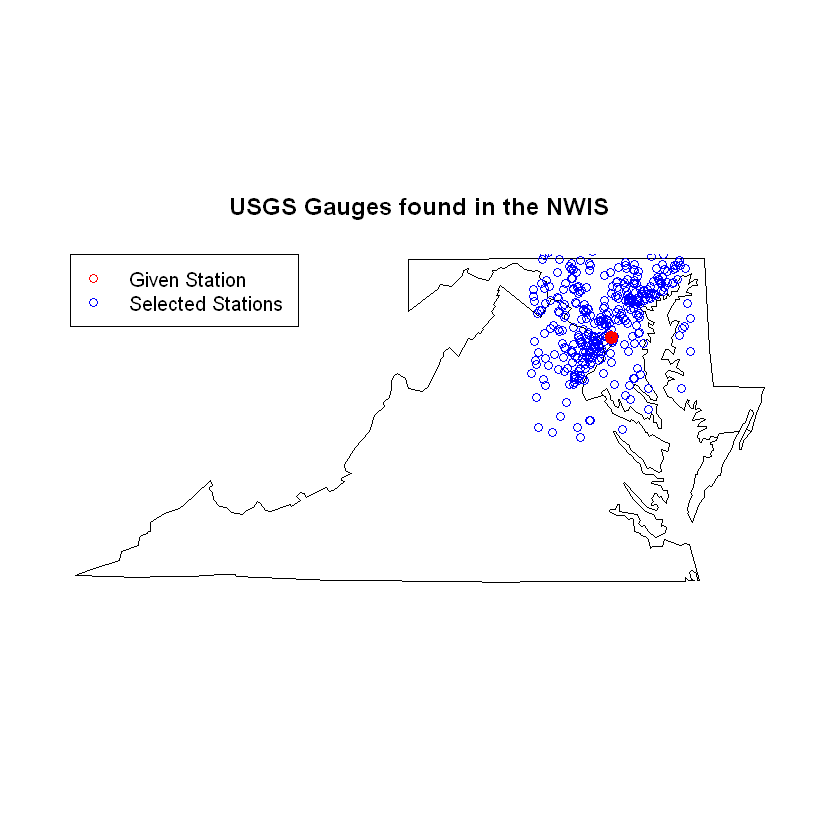

In [5]:
map('state', region = c('maryland','virginia', 'washingtondc'))
#map('state', region = c('mississippi'))
title(main="USGS Gauges found in the NWIS")
points(x=para_sites$dec_long_va, 
       y=para_sites$dec_lat_va,
      col='blue')
points(x=site_long,
       y=site_lat,
       lwd=5,
       col='red')
legend( x="topleft", 
        legend=c("Given Station","Selected Stations"),
        col=c("red","blue"), lwd=1, lty=c(0,0), 
        pch=c(1,1) )

In [6]:
# Filter the retrieved USGS gages based on the defined criteria
sites_meta <- whatNWISdata(siteNumber=para_sites$site_no, parameterCd=paraCode)
sites_meta_years <- sites_meta[(sites_meta['end_date'] - sites_meta['begin_date']) > (years_of_records * 365.0),]
sites_summary <- readNWISsite(siteNumber=sites_meta_years$site_no)
sites_selected <- sites_summary[((1-da_epsilon)* site_da) <= sites_summary['drain_area_va'] & sites_summary['drain_area_va'] <= ((1+da_epsilon)* site_da), ]

select(sites_selected, site_no, station_nm, lat_va, long_va, drain_area_va)

,site_no,station_nm,lat_va,long_va,drain_area_va
16,01582000,"LITTLE FALLS AT BLUE MOUNT, MD",393614.7,763713.7,52.9
20,01583500,"WESTERN RUN AT WESTERN RUN, MD",393038.8,764035.4,59.8
34,01586000,"NORTH BRANCH PATAPSCO RIVER AT CEDARHURST, MD",393010.8,765303.8,56.6
49,01589478,"JONES FALLS AT MARYLAND AVE AT BALTIMORE, MD",391833.5,763709.9,54.9
60,01593500,"LITTLE PATUXENT RIVER AT GUILFORD, MD",391003.9,765104.5,38.0
92,01646000,"DIFFICULT RUN NEAR GREAT FALLS, VA",385833.0,771446.0,57.8
101,01651000,"NORTHWEST BR ANACOSTIA RIVER NR HYATTSVILLE, MD",385708.4,765757.8,49.4
106,01653600,"PISCATAWAY CREEK AT PISCATAWAY, MD",384220.8,765758.3,39.5
112,01656500,"BROAD RUN AT BUCKLAND, VA",384650.0,774022.0,50.2
115,01658000,"MATTAWOMAN CREEK NEAR POMONKEY, MD",383546.1,770321.7,54.8


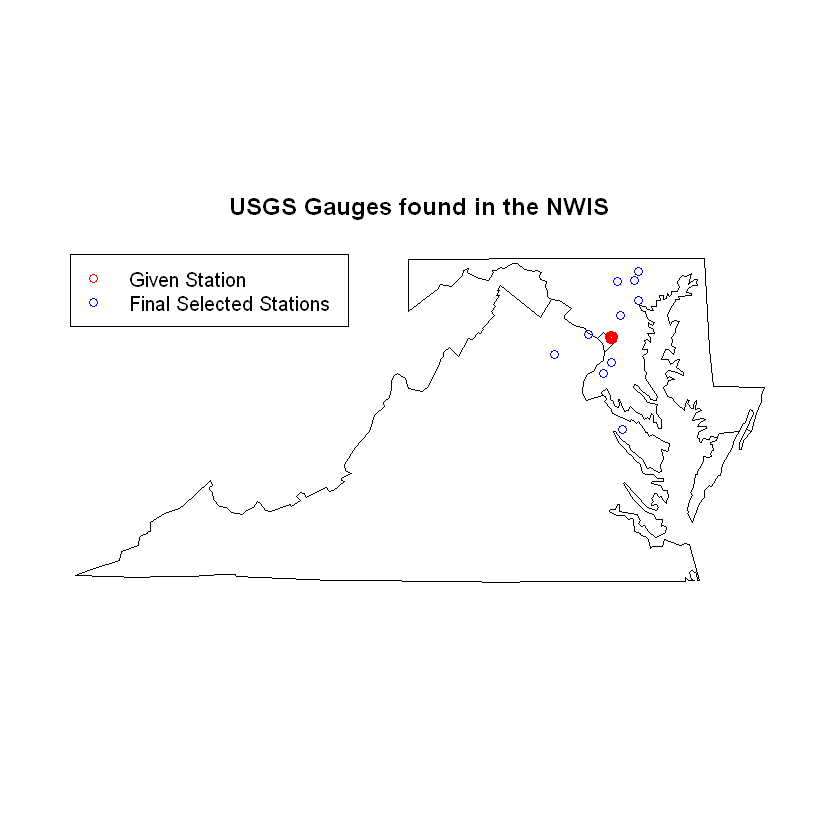

In [7]:
map('state', region = c('maryland','virginia', 'washingtondc'))
#map('state', region = c('mississippi'))
title(main="USGS Gauges found in the NWIS")
points(x=sites_selected$dec_long_va, 
       y=sites_selected$dec_lat_va,
      col='blue')
points(x=site_long,
       y=site_lat,
       lwd=5,
       col='red')
legend( x="topleft", 
        legend=c("Given Station","Final Selected Stations"),
        col=c("red","blue"), lwd=1, lty=c(0,0), 
        pch=c(1,1) )